Рассматривается динамическая система, представляющая собой демпфированный маятник на пружине. Система имеет следующие характеристики: m = 1 кг - масса тележки, b = 10 Нс/м - коэффициент дэмпфирования, k = 20 Н/м - жесткость пружины, F = u = 1 Н.
\
Уравнение, описывающее систему:
$$ m \cdot \ddot{x} + b \cdot \dot{x} + k \cdot x = u $$
\
Представим систему в стандартном представлении в пространстве состояний:
$$ \dot{X} = A \cdot X + B \cdot u,$$ 
$$Y = C \cdot X + D \cdot u,$$
\
Предполагаем, что в данной системе матрица наблюдения имеет вид $C = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$,а матрица связи $D$ является нулевой, это означает, что в системе нет явной прямой связи выходной величины с измеряемым значением.

Приведем систему к нормальному виду:
$$
\begin{equation*}
 \begin{cases}
   \dot{x_1} = x_2, 
   \\
   \dot{x_2} = -\frac{k}{m}x_1 - \frac{b}{m}x_2 + u.
 \end{cases}
\end{equation*}
$$
\
Таким образом, из данной системы можно получить матрицы $A$ и $B$:
$$ A =\begin{bmatrix}
0& 1\\
-\frac{k}{m}& - \frac{b}{m}
\end{bmatrix},$$
\
$$ B =\begin{bmatrix}
0\\
1
\end{bmatrix}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import control
from control import *

In [2]:
# Инициализация системы
M = 1  #кг
B = 10 #Нс/м
K = 20 #Н/м

In [3]:
def Dyn_ST_TF():
    A_st=[[0, 1], [-B/M, -K/M]]
    B_st=[0,1]
    C_st=[1,0]
    D_st=[0]
    TF_st=control.ss2tf(A_st, B_st, C_st, D_st)
    return TF_st

In [4]:
def PID_TF_Generator(D,P,I):
    PID_Num=[D,P,I]
    PID_Den=[1,0]
    PID_TF=control.tf(PID_Num,PID_Den)
    return PID_TF

In [5]:
def PID_Response(PID_TF,TF_st):
    FeedBack = feedback(PID_TF*TF_st,1)
    Time=list(np.arange(0,40,0.1))
    Time, y = control.step_response(sys=FeedBack,T=Time,X0=0)
    return Time,y

Показателем эффективности в данной задаче положим суммы нескольких ошибок регулятора,взятых с определенными весами. К таковым ошибкам относим:
\
Интегральная квадратичная ошибка → $ISE = \int\limits_{0}^{T} e^2(t) dt,$
\
Интегральная абсолютная ошибка → $IAE = \int\limits_{0}^{T} |e|(t)dt,$
\
Абсолютная интегральная ошибка по времени → $ITAE = \int\limits_{0}^{T} t|e|dt,$
\
Квадратичная интегральная ошибка по времени → $ITSE = \int\limits_{0}^{T} te^2dt,$
\
Перерегулирование → $overshoot$,
\
Время нарастания → $t_{rise}$.

Соответствующие веса взяты из $\href{https://www.researchgate.net/publication/252840849_Genetic_Algorithms_for_PID_Parameter_Optimisation_Minimising_Error_Criteria}{статьи}$.

Функция качества принимает вид:
$$ J = 5 \cdot ISE + 5 \cdot IAE + 1 \cdot ITAE + 1 \cdot ITSE + 4 \cdot t_{rise} = 5 \int\limits_{0}^{T} e^2(t) dt + 5 \int\limits_{0}^{T} |e|(t)dt + \int\limits_{0}^{T} t|e|dt + \int\limits_{0}^{T} te^2dt + 4 \cdot t_{rise}→ min $$
\
или в более стандратной форме:
$$ -5 \cdot ISE - 5 \cdot IAE - ITAE - ITSE - 4 \cdot t_{rise} → max $$

In [6]:
def PID_Error_Generator(D,P,I):
    TF_gr=Dyn_ST_TF()
    w1=5
    w2=5
    w3=1
    w4=1
    w5=4
    w6=0

    PID_TF=PID_TF_Generator(D,P,I)
    Time,y=PID_Response(PID_TF,TF_gr)

    y_np=np.array(y.copy())
    Error=1-y_np
    Absolute_Error=np.abs(Error)
    Square_Error=Error**2
    Overshoot=np.max(y_np)-1

    Overshoot_Index=np.where(y_np==(1+Overshoot))[0]
    Overshoot_location=np.argmax(y)/10

    Rise_Time=0
    IAE = np.trapz(Absolute_Error, dx=0.01)
    ISE = np.trapz(Square_Error, dx=0.01)
    ITAE = np.trapz((Time*Absolute_Error), dx=0.01)
    ITSE = np.trapz((Time*Square_Error), dx=0.01)

    W=w1*IAE+w2*ISE+w3*ITAE+w4*ITSE+w5*Rise_Time+w6*Overshoot
    return W,y,Time,IAE,ISE,ITAE,ITSE,Rise_Time,Overshoot

In [7]:
def create_population(population_size, parameters, sub_chromosome_length,problem_boundary):

    population_sub1_ = np.random.uniform(-problem_boundary[0], problem_boundary[0], size=(population_size, 1))
    population_sub2_ = np.random.uniform(-problem_boundary[1], problem_boundary[1], size=(population_size, 1))
    population_sub3_ = np.random.uniform(-problem_boundary[2], problem_boundary[2], size=(population_size, 1))
    sub_chromosome_matrix=np.ones((population_size,sub_chromosome_length))/sub_chromosome_length
    
    population_sub1=population_sub1_*sub_chromosome_matrix
    population_sub2=population_sub2_*sub_chromosome_matrix
    population_sub3=population_sub3_*sub_chromosome_matrix
    
    population_sub12=np.hstack((population_sub1,population_sub2))
    population=np.hstack((population_sub12,population_sub3))


    return population

In [8]:
def boundary_checker(population,parameters,sub_chromosome_length,problem_boundary):

    Feature1=population[:,0:sub_chromosome_length]
    Feature2=population[:,sub_chromosome_length:2*sub_chromosome_length]
    Feature3=population[:,2*sub_chromosome_length:]
    Initial_Length=len(population)

    
    P=np.sum(Feature1,keepdims=True,axis=1)
    maskP=np.abs(P)>problem_boundary[0]
    D=np.sum(Feature2,keepdims=True,axis=1)
    maskD=np.abs(D)>problem_boundary[1]
    I=np.sum(Feature3,keepdims=True,axis=1)
    maskI=np.abs(I)>problem_boundary[2]
    maskPD=np.hstack((maskP,maskD))
    maskPDI=np.hstack((maskPD,maskI))
    
    
    mask=np.invert(np.any(maskPDI,axis=1))
    population_checked=population[mask]

    return population_checked

In [9]:
def calculate_fitness(population_checked,sub_chromosome_length):
    
    Feature1=population_checked[:,0:sub_chromosome_length]
    Feature2=population_checked[:,sub_chromosome_length:2*sub_chromosome_length]
    Feature3=population_checked[:,2*sub_chromosome_length:]

    X=(np.sum(Feature1,axis=1)).tolist()
    Y=(np.sum(Feature2,axis=1)).tolist()
    Z=(np.sum(Feature3,axis=1)).tolist()

    GA_Errors=[]
    for ns in range(len(X)):
        TTTT,*_=PID_Error_Generator(X[ns],Y[ns],Z[ns])
        GA_Errors.append(TTTT)
    GA_Errors=np.reshape(GA_Errors,newshape=(np.shape(population_checked)[0],1))
    population_with_fitness=np.hstack((GA_Errors,population_checked))
        
    return population_with_fitness

In [10]:
def chromosome_to_result(Champ,sub_chromosome_length):
    Champ1=Champ[1:]
    Feature_1=Champ1[0:sub_chromosome_length]
    Feature_2=Champ1[sub_chromosome_length:2*sub_chromosome_length]
    Feature_3=Champ1[2*sub_chromosome_length:]

    Champ_X=(np.sum(Feature_1)).tolist()
    Champ_Y=(np.sum(Feature_2)).tolist()
    Champ_Z=(np.sum(Feature_3)).tolist()
    Champ_W,Champ_y,Champ_Time,*_=PID_Error_Generator(Champ_X,Champ_Y,Champ_Z)
    
    return Champ_X,Champ_Y,Champ_Z,Champ_W,Champ_y,Champ_Time

In [11]:
def sort_population(population_with_fitness,population_size):
    population_sorted_=population_with_fitness[population_with_fitness[:,0].argsort()]
    population_sorted=population_sorted_[0:population_size]

    return population_sorted

In [12]:
def breed_by_crossover(parent_1, parent_2,crossovers):

    chromosome_length = len(parent_1)-1
    crossover_points = np.sort(np.random.choice(range(1,chromosome_length),size=crossovers,replace=False))
    parents=[parent_1,parent_2]
    j=0
    k=1
    for point in crossover_points:
        child1 = np.hstack((parents[0][0:point],parents[k][point:]))
        child2 = np.hstack((parents[1][0:point],parents[j][point:]))
        parents[0]=child1.copy()
        parents[1]=child2.copy()
        j,k=k,j
    children=np.vstack((parents[0],parents[1]))
    
    return children

In [13]:
def population_generator(population_sorted,population_size,mutation_rate,crossovers,mutation_per_chromosome):
    
    quarter_size=int(population_size/4)
    selected_index=np.random.permutation(2*quarter_size)
    parent_one_list=selected_index[0:quarter_size]
    parent_two_list=selected_index[quarter_size:]
    population_no_score=np.delete(population_sorted,0,axis=1)
    population_for_breeding=population_no_score[:2*quarter_size]

    for i in range(quarter_size):
        parent_1=population_for_breeding[parent_one_list[i],:]
        parent_2=population_for_breeding[parent_two_list[i],:]
        children=breed_by_crossover(parent_1, parent_2,crossovers)
        population_for_breeding=np.vstack((population_for_breeding,children))

    population_for_mutation=population_for_breeding.copy()
    population_after_mutation=randomly_mutate_population(population_for_mutation, mutation_rate,mutation_per_chromosome)
    population=population_after_mutation.copy()
    return population

In [14]:
def randomly_mutate_population(population_for_mutation, mutation_rate,mutation_per_chromosome):
    
    (people,chromosome_length)=np.shape(population_for_mutation)
    keep=1
    max_val=np.max(population_for_mutation)
    min_val=np.min(population_for_mutation)
    muts1=int(mutation_rate*people)
    mutation_people=np.random.choice(range(keep,people),size=muts1,replace=False)

    for num in mutation_people:
        mutant_genes=np.random.choice(range(0,chromosome_length),size=mutation_per_chromosome,replace=False)
        for mutant_gene in mutant_genes:
            population_for_mutation[num,mutant_gene]=np.random.uniform(min_val, max_val)
    population_after_mutation=population_for_mutation.copy()
    return population_after_mutation

In [15]:
def Plot_Error_Per_Generation(best_score_progress):
    plt.plot(best_score_progress)
    plt.xlabel('Поколение')
    plt.ylabel('Ошибка(% от целевого значения)')
    plt.grid()
    plt.show()

In [16]:
def Result_Plotter(Time,y):
    plt.plot(Time, y)
    plt.xlabel('Время,сек')
    plt.ylabel('Амплитуда')
    plt.title('Отклик на ступенчатый вход от PID-регулятора')
    plt.grid()

In [17]:
problem_boundary=[2,4,2]
sub_chromosome_length = 10
crossovers=5
population_size = 100
maximum_generation = 100
best_score_progress = []
parameters=3
mutation_rate = 0.5
mutation_per_chromosome=5
chromosome_length=parameters*sub_chromosome_length

population = create_population(population_size, parameters, sub_chromosome_length,problem_boundary)
population_with_fitness= calculate_fitness(population,sub_chromosome_length)
population_sorted=sort_population(population_with_fitness,population_size)

best_score = population_sorted[0,0]
best_score_progress.append(best_score)
population_with_fitness=[]


for generation in range(maximum_generation):
    
    population=population_generator(population_sorted,population_size,mutation_rate,crossovers,mutation_per_chromosome)
    population_checked=boundary_checker(population,parameters,sub_chromosome_length,problem_boundary)
    population_with_fitness= calculate_fitness(population_checked,sub_chromosome_length)
    population_sorted=sort_population(population_with_fitness,population_size)

    best_score = population_sorted[0,0]
    best_score_progress.append(best_score)
    
    Champ=population_sorted[0]
    Champ_X,Champ_Y,Champ_Z,Champ_W,Champ_y,Champ_Time=chromosome_to_result(Champ,sub_chromosome_length)
    #print(f'Решение в данном поколении {generation}: ', Champ_X,Champ_Y,Champ_Z')
    #print('Ошибка: ',Champ_W)
    #print('----------------------------------------------------------')



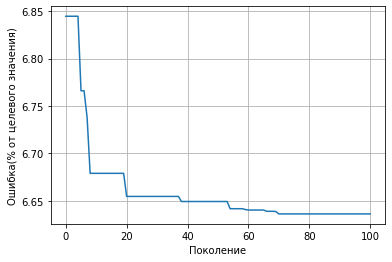

In [18]:
Plot_Error_Per_Generation(best_score_progress)

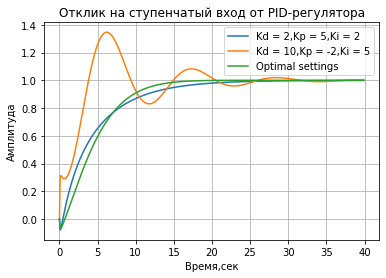

In [19]:
TF_gr=Dyn_ST_TF()

#1: Kd = -2,Kp = 4,Ki = 2
PID_TF_1=PID_TF_Generator(-2,4,2)
Time_1,y_1=PID_Response(PID_TF_1,TF_gr)

#2: Kd = 10,Kp = -2,Ki = 5
PID_TF_2=PID_TF_Generator(10,-2,10)
Time_2,y_2=PID_Response(PID_TF_2,TF_gr)


plt.plot(Time_1,y_1,label ='Kd = 2,Kp = 5,Ki = 2')
plt.plot(Time_2,y_2,label ='Kd = 10,Kp = -2,Ki = 5')
plt.plot(Champ_Time,Champ_y, label = 'Optimal settings')

plt.xlabel('Время,сек')
plt.ylabel('Амплитуда')
plt.title('Отклик на ступенчатый вход от PID-регулятора')
plt.grid()

plt.legend()
plt.show()

In [20]:
Kd = Champ_X
Kp = Champ_Y
Ki = Champ_Z
print('Оптимальные настройки PID-регулятора:')
print('Kd = ',round(Kd,5))
print('Kp = ',round(Kp,5))
print('Ki = ',round(Ki,5))

Оптимальные настройки PID-регулятора:
Kd =  -1.60565
Kp =  1.21619
Ki =  1.998
